## Observations and Insights 

In [69]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import sem

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset

mouse_data_complete = pd.merge(mouse_metadata, study_results, how="left", on=["Mouse ID", "Mouse ID"])

# Display the data table for preview

#mouse_data_complete

In [70]:
# Checking the number of mice.

total_mice = len(mouse_data_complete.groupby('Mouse ID'))

total_mice

249

In [71]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

duplicated = mouse_data_complete[mouse_data_complete.duplicated(['Mouse ID','Timepoint'])]

#duplicated

In [72]:
# Optional: Get all the data for the duplicate mouse ID. 


In [73]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.

clean_data_complete = mouse_data_complete.drop_duplicates(subset = ["Mouse ID","Timepoint"], keep = False)

#clean_data_complete

In [74]:
# Checking the number of mice in the clean DataFrame.

len(clean_data_complete)


1883

## Summary Statistics

In [75]:
# Generate a summary statistics table of mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each regimen
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

drug_groupby = clean_data_complete.groupby('Drug Regimen')

mean_volume = drug_groupby.mean()['Tumor Volume (mm3)']
median_volume = drug_groupby.median()['Tumor Volume (mm3)']
variance_volume = drug_groupby.var()['Tumor Volume (mm3)']
sd_volume = drug_groupby.std()['Tumor Volume (mm3)']
sem_volume = drug_groupby.sem()['Tumor Volume (mm3)']

volume_summary = pd.DataFrame({
                    "Mean Tumor Volume": mean_volume,
                    "Median Tumor Volume": median_volume,
                    "Variance of Tumor Volume": variance_volume,
                    "Standard Deviation of Tumor Volume": sd_volume,
                    "Standard Error of Tumor Volume": sem_volume,
})

#volume_summary

In [76]:
# Generate a summary statistics table of mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each regimen
# Using the aggregation method, produce the same summary statistics in a single line

agg_volume_summary = clean_data_complete.groupby("Drug Regimen").agg({"Tumor Volume (mm3)": ['mean','median','var','std','sem']})

#agg_volume_summary


## Bar and Pie Charts

<AxesSubplot:xlabel='Drug Regimen'>

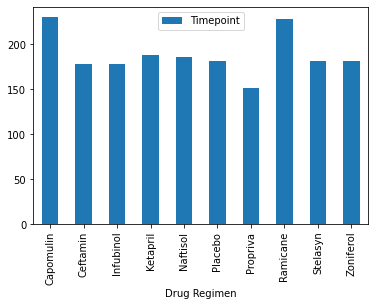

In [122]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

drug_counts = clean_data_complete.groupby('Drug Regimen').count()

drug_counts.plot(kind = 'bar', y = 'Timepoint')


<BarContainer object of 10 artists>

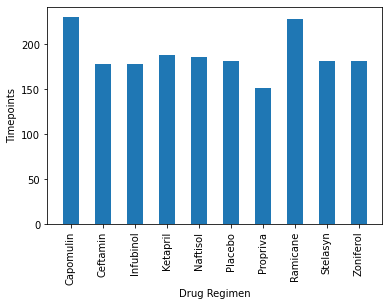

In [123]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.

x_axis = drug_counts.index.values
y_axis = drug_counts['Timepoint'].values

plt.xlabel('Drug Regimen')
plt.xticks(rotation='vertical')
plt.ylabel('Timepoints')

plt.bar(x_axis, y_axis, width = 0.5)

<AxesSubplot:ylabel='Drug Regimen'>

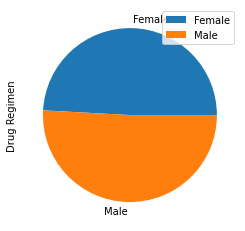

In [124]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

gender_counts = clean_data_complete.groupby('Sex').count()

gender_counts.plot(kind = 'pie', y = 'Drug Regimen')

([<matplotlib.patches.Wedge at 0x7fa1bc6ad8b0>,
 [Text(0.030277540496140565, 1.099583225836728, 'Female'),
  Text(-0.030277540496141186, -1.099583225836728, 'Male')])

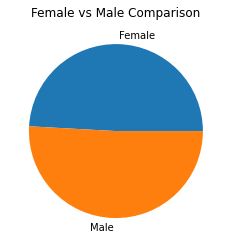

In [125]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

plt.title("Female vs Male Comparison")
plt.pie(gender_counts['Drug Regimen'], labels = ['Female', 'Male'])


## Quartiles, Outliers and Boxplots

In [156]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

max_df = clean_data_complete.groupby(['Mouse ID'])['Timepoint'].max()
max_df = max_df.reset_index()

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint

merged_df = max_df.merge(clean_data_complete, on = ['Mouse ID','Timepoint'])

merged_df

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites
0,a203,45,Infubinol,Female,20,23,67.973419,2
1,a251,45,Infubinol,Female,21,25,65.525743,1
2,a262,45,Placebo,Female,17,29,70.717621,4
3,a275,45,Ceftamin,Female,20,28,62.999356,3
4,a366,30,Stelasyn,Female,16,29,63.440686,1
...,...,...,...,...,...,...,...,...
244,z435,10,Propriva,Female,12,26,48.710661,0
245,z578,45,Ramicane,Male,11,16,30.638696,0
246,z581,45,Infubinol,Female,24,25,62.754451,3
247,z795,45,Naftisol,Female,13,29,65.741070,3


In [159]:
# Put treatments into a list for for loop (and later for plot labels)

treatments = ['Capomulin','Ramicane','Infubinol','Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)

tumor_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

for treatment in treatments:
    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    drug_volume = merged_df.loc[merged_df['Drug Regimen'] == treatment][['Tumor Volume (mm3)']]
    
    # add subset 
    tumor_data.append(drug_volume['Tumor Volume (mm3)'])

    # Determine outliers using upper and lower bounds
    
quartiles = tumor_data['Tumor Volume (mm3)'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Volumes is: {lowerq}")
print(f"The upper quartile of Volumes is: {upperq}")
print(f"The interquartile range of Volumes is: {iqr}")
print(f"The the median of Volumes is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")
    
plt.boxplot(tumor_data, labels = treatments)
plt.show()




TypeError: list indices must be integers or slices, not str

In [153]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [164]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

x_axis = clean_data_complete['Tumor Volume (mm3)']
y_axis = clean_data_complete['Timepoint']

pd.clean_data_complete.plot.line(x_axis, y_axis)

AttributeError: module 'pandas' has no attribute 'clean_data_complete'

In [160]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

x_axis = clean_data_complete['Tumor Volume (mm3)']
y_axis = clean_data_complete['Timepoint']

pd.clean_data_complete.plot.line(x_axis, y_axis)

AttributeError: module 'pandas' has no attribute 'clean_data_complete'

## Correlation and Regression

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
